# Title of notebook

Brief 1-2 sentence description of notebook.

In [1]:
# Imports of all used packages and libraries
import os
import glob
import bisect

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from scipy.signal import butter, filtfilt, hilbert


In [2]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp

## Inputs & Data

Explanation of each input and where it comes from.

In [3]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc/" # where data is saved should always be shown in the inputs
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
CHANNEL_MAPPING_DF = pd.read_excel("../../data/channel_mapping.xlsx")
TONE_TIMESTAMP_DF = pd.read_excel("../../data/rce_tone_timestamp.xlsx", index_col=0)
CHANNEL_MAP_AND_ALL_TRIALS_DF = pd.read_pickle("./proc/full_baseline_and_trial_lfp_traces.pkl")
MERGED_SPIKE_TRIAL_DF = pd.read_pickle("./proc/merged_spike_trial.pkl")

In [5]:
TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.5
RESAMPLE_RATE=1000
LFP_SAMPLING_RATE=1000
EPHYS_SAMPLING_RATE=20000
TRIAL_DURATION=10

In [6]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [7]:
BASELINE_OUTCOME_TO_COLOR = {'lose': "red",
 'omission': "orange",
 'rewarded': "green",
 'win': "blue"}

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [8]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names

def calc_bmi(weight, height):
    """
    This is a function that calculates BMI.
    it uses height and weight...etc.
    Meghan plz show us your docsctring format here.
    """
    bmi = weight/(height**2)
    return(bmi)


In [9]:

def find_closest_nums(list1, list2):
    """
    For each number in list1, find the closest number in list2.

    Args:
    - list1 (list): An ordered list of numbers.
    - list2 (list): Another ordered list of numbers.

    Returns:
    - list: A list of closest numbers from list2 for each number in list1.
    """
    closest_nums = []

    for num in list1:
        # Find where the number would be inserted in list2
        position = bisect.bisect_left(list2, num)

        # If the number is actually present in list2, then return it
        if position != len(list2) and list2[position] == num:
            closest_nums.append(num)
        # Else find the closest of the two neighbors
        else:
            if position == 0:
                closest_nums.append(list2[0])
            elif position == len(list2):
                closest_nums.append(list2[-1])
            else:
                before = list2[position - 1]
                after = list2[position]
                closest_nums.append(before if num - before <= after - num else after)

    return closest_nums



In [10]:
def find_closest_indices(list1, list2):
    """
    For each number in list1, find the index of the closest number in list2.

    Args:
    - list1 (list): An ordered list of numbers.
    - list2 (list): Another ordered list of numbers.

    Returns:
    - list: A list of indices of the closest numbers from list2 for each number in list1.
    """
    closest_indices = []

    for num in list1:
        # Find where the number would be inserted in list2
        position = bisect.bisect_left(list2, num)

        # If the number is actually present in list2, then return its index
        if position != len(list2) and list2[position] == num:
            closest_indices.append(position)
        # Else find the index of the closest of the two neighbors
        else:
            if position == 0:
                closest_indices.append(0)
            elif position == len(list2):
                closest_indices.append(len(list2) - 1)
            else:
                before = list2[position - 1]
                after = list2[position]
                closest_indices.append(position - 1 if num - before <= after - num else position)

    return closest_indices


# Reading in spike data

In [11]:
rec_file = MERGED_SPIKE_TRIAL_DF["recording_file"].unique()[0]

In [12]:
rec_file

'20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged'

In [13]:
CHANNEL_MAP_AND_ALL_TRIALS_DF[CHANNEL_MAP_AND_ALL_TRIALS_DF["recording_file"] == rec_file].iloc[0]

time                                                                        8260195
recording_dir                     20230620_114347_standard_comp_to_omission_D4_s...
recording_file                    20230620_114347_standard_comp_to_omission_D4_s...
time_stamp_index                                                            5757314
video_file                        20230620_114347_standard_comp_to_omission_D4_s...
video_frame                                                                    5755
video_number                                                                    1.0
subject_info                                                        1-1_t1b2L_box_2
competition_closeness                                                     lose_comp
video_name                        20230620_114347_standard_comp_to_omission_D4_s...
all_subjects                                                             (1.1, 1.2)
current_subject                                                             

In [14]:
MERGED_SPIKE_TRIAL_DF

,spike_clusters,spike_times,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,...,competition_closeness,Unnamed: 13,resampled_index,all_subjects,current_subject,trial_outcome,trial_number,trial_chunked_ephys_timestamp,timestamp_bin,relative_time_to_tone
0,64,5557899,64,4,1,12,10.794415,14,0.0,280.0,...,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[5557314, 5559314, 5561314, 5563314, 5565314, ...",-100,-199415
1,89,5557965,89,11,11,13,17.238409,26,0.0,520.0,...,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[5557314, 5559314, 5561314, 5563314, 5565314, ...",-100,-199349
2,60,5558325,60,0,0,0,26.088383,5,0.0,100.0,...,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[5557314, 5559314, 5561314, 5563314, 5565314, ...",-100,-198989
3,64,5559142,64,4,1,12,10.794415,14,0.0,280.0,...,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[5557314, 5559314, 5561314, 5563314, 5565314, ...",-100,-198172
4,89,5559232,89,11,11,13,17.238409,26,0.0,520.0,...,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[5557314, 5559314, 5561314, 5563314, 5565314, ...",-100,-198082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103994,204,38675317,204,1,0,1,11.366614,6,0.0,120.0,...,,NaN,1923872,"[1.2, 1.4]",1.4,rewarded,16,"[38277451, 38279451, 38281451, 38283451, 38285...",98,197866
103995,44,38675962,44,3,1,29,9.739503,17,0.0,340.0,...,,NaN,1923872,"[1.2, 1.4]",1.4,rewarded,16,"[38277451, 38279451, 38281451, 38283451, 38285...",99,198511
103996,204,38676329,204,1,0,1,11.366614,6,0.0,120.0,...,,NaN,1923872,"[1.2, 1.4]",1.4,rewarded,16,"[38277451, 38279451, 38281451, 38283451, 38285...",99,198878
103997,134,38677144,134,5,4,17,8.562255,2,0.0,40.0,...,,NaN,1923872,"[1.2, 1.4]",1.4,rewarded,16,"[38277451, 38279451, 38281451, 38283451, 38285...",99,199693


In [15]:
example_spike_df = MERGED_SPIKE_TRIAL_DF[(MERGED_SPIKE_TRIAL_DF["recording_file"] == rec_file) & (MERGED_SPIKE_TRIAL_DF["trial_number"] == 16) & (MERGED_SPIKE_TRIAL_DF["timestamp_bin"] >= 0)].copy()

In [46]:
example_spike_df

,spike_clusters,spike_times,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,...,competition_closeness,Unnamed: 13,resampled_index,all_subjects,current_subject,trial_outcome,trial_number,trial_chunked_ephys_timestamp,timestamp_bin,relative_time_to_tone
11775,2,41758622,2,0,0,0,24.692951,1,0.0,20.0,...,,NaN,2087887,"[1.2, 1.1]",1.1,rewarded,16,"[41557758, 41559758, 41561758, 41563758, 41565...",0,864
11776,20,41759432,20,0,0,0,19.467382,11,0.0,220.0,...,,NaN,2087887,"[1.2, 1.1]",1.1,rewarded,16,"[41557758, 41559758, 41561758, 41563758, 41565...",0,1674
11777,89,41759557,89,11,11,13,17.238409,26,0.0,520.0,...,,NaN,2087887,"[1.2, 1.1]",1.1,rewarded,16,"[41557758, 41559758, 41561758, 41563758, 41565...",0,1799
11778,60,41759771,60,0,0,0,26.088383,5,0.0,100.0,...,,NaN,2087887,"[1.2, 1.1]",1.1,rewarded,16,"[41557758, 41559758, 41561758, 41563758, 41565...",1,2013
11779,60,41759894,60,0,0,0,26.088383,5,0.0,100.0,...,,NaN,2087887,"[1.2, 1.1]",1.1,rewarded,16,"[41557758, 41559758, 41561758, 41563758, 41565...",1,2136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12088,64,41954563,64,4,1,12,10.794415,14,0.0,280.0,...,,NaN,2087887,"[1.2, 1.1]",1.1,rewarded,16,"[41557758, 41559758, 41561758, 41563758, 41565...",98,196805
12089,89,41955116,89,11,11,13,17.238409,26,0.0,520.0,...,,NaN,2087887,"[1.2, 1.1]",1.1,rewarded,16,"[41557758, 41559758, 41561758, 41563758, 41565...",98,197358
12090,2,41956424,2,0,0,0,24.692951,1,0.0,20.0,...,,NaN,2087887,"[1.2, 1.1]",1.1,rewarded,16,"[41557758, 41559758, 41561758, 41563758, 41565...",99,198666
12091,89,41956843,89,11,11,13,17.238409,26,0.0,520.0,...,,NaN,2087887,"[1.2, 1.1]",1.1,rewarded,16,"[41557758, 41559758, 41561758, 41563758, 41565...",99,199085


In [16]:
example_spike_df.groupby("cluster_id").count()

,spike_clusters,spike_times,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,fr,...,competition_closeness,Unnamed: 13,resampled_index,all_subjects,current_subject,trial_outcome,trial_number,trial_chunked_ephys_timestamp,timestamp_bin,relative_time_to_tone
cluster_id,,,,,,,,,,,,,,,,,,,,,
2,40,40,40,40,40,40,40,40,40,40,...,40,0,40,40,40,40,40,40,40,40
20,15,15,15,15,15,15,15,15,15,15,...,15,0,15,15,15,15,15,15,15,15
57,3,3,3,3,3,3,3,0,3,3,...,3,0,3,3,3,3,3,3,3,3
60,32,32,32,32,32,32,32,32,32,32,...,32,0,32,32,32,32,32,32,32,32
64,34,34,34,34,34,34,34,34,34,34,...,34,0,34,34,34,34,34,34,34,34
85,15,15,15,15,15,15,15,15,15,15,...,15,0,15,15,15,15,15,15,15,15
89,162,162,162,162,162,162,162,162,162,162,...,162,0,162,162,162,162,162,162,162,162
90,9,9,9,9,9,9,9,9,9,9,...,9,0,9,9,9,9,9,9,9,9
94,8,8,8,8,8,8,8,8,8,8,...,8,0,8,8,8,8,8,8,8,8


In [17]:
example_spike_df[example_spike_df["spike_clusters"] == 89]["spike_times"]

11777    41759557
11780    41761536
11783    41762244
11786    41765408
11790    41768600
           ...   
12085    41951656
12086    41952077
12089    41955116
12091    41956843
12092    41957333
Name: spike_times, Length: 162, dtype: int64

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a4490980-3f6a-4f44-80eb-ebd789a5b21f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

# Filtering and Phase

# Example

In [18]:
CHANNEL_MAP_AND_ALL_TRIALS_DF["lfp_trace_trial_all_lfp_index"] = CHANNEL_MAP_AND_ALL_TRIALS_DF["lfp_index"].apply(lambda x: np.arange(x,x+TRIAL_DURATION*LFP_SAMPLING_RATE))

CHANNEL_MAP_AND_ALL_TRIALS_DF["lfp_trace_baseline_all_lfp_index"] = CHANNEL_MAP_AND_ALL_TRIALS_DF["lfp_index"].apply(lambda x: np.arange(x-TRIAL_DURATION*LFP_SAMPLING_RATE, x))

In [19]:
CHANNEL_MAP_AND_ALL_TRIALS_DF["lfp_trace_trial_all_ephys_index"] = CHANNEL_MAP_AND_ALL_TRIALS_DF["time_stamp_index"].apply(lambda x: np.arange(x,x+EPHYS_SAMPLING_RATE*TRIAL_DURATION, int(EPHYS_SAMPLING_RATE/LFP_SAMPLING_RATE)))

CHANNEL_MAP_AND_ALL_TRIALS_DF["lfp_trace_baseline_all_ephys_index"] = CHANNEL_MAP_AND_ALL_TRIALS_DF["time_stamp_index"].apply(lambda x: np.arange(x-EPHYS_SAMPLING_RATE*TRIAL_DURATION, x, int(EPHYS_SAMPLING_RATE/LFP_SAMPLING_RATE)))

In [20]:
CHANNEL_MAP_AND_ALL_TRIALS_DF["recording_file"]

0      20221202_134600_omission_and_competition_subje...
1      20221202_134600_omission_and_competition_subje...
2      20221202_134600_omission_and_competition_subje...
3      20221202_134600_omission_and_competition_subje...
4      20221202_134600_omission_and_competition_subje...
                             ...                        
578    20230621_111240_standard_comp_to_omission_D5_s...
579    20230621_111240_standard_comp_to_omission_D5_s...
580    20230621_111240_standard_comp_to_omission_D5_s...
581    20230621_111240_standard_comp_to_omission_D5_s...
582    20230621_111240_standard_comp_to_omission_D5_s...
Name: recording_file, Length: 583, dtype: object

In [21]:
example_spike_df.groupby("cluster_id").count()

,spike_clusters,spike_times,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,fr,...,competition_closeness,Unnamed: 13,resampled_index,all_subjects,current_subject,trial_outcome,trial_number,trial_chunked_ephys_timestamp,timestamp_bin,relative_time_to_tone
cluster_id,,,,,,,,,,,,,,,,,,,,,
2,40,40,40,40,40,40,40,40,40,40,...,40,0,40,40,40,40,40,40,40,40
20,15,15,15,15,15,15,15,15,15,15,...,15,0,15,15,15,15,15,15,15,15
57,3,3,3,3,3,3,3,0,3,3,...,3,0,3,3,3,3,3,3,3,3
60,32,32,32,32,32,32,32,32,32,32,...,32,0,32,32,32,32,32,32,32,32
64,34,34,34,34,34,34,34,34,34,34,...,34,0,34,34,34,34,34,34,34,34
85,15,15,15,15,15,15,15,15,15,15,...,15,0,15,15,15,15,15,15,15,15
89,162,162,162,162,162,162,162,162,162,162,...,162,0,162,162,162,162,162,162,162,162
90,9,9,9,9,9,9,9,9,9,9,...,9,0,9,9,9,9,9,9,9,9
94,8,8,8,8,8,8,8,8,8,8,...,8,0,8,8,8,8,8,8,8,8


In [22]:
# Group by 'Group' column and get group sizes
group_sizes = example_spike_df.groupby('cluster_id').size()

# Identify the group with the largest count
group_with_max_count = group_sizes.idxmax()
print(f"The group with the largest count is: {group_with_max_count}")

# If you also want to retrieve the actual rows of that group:
max_group_data = example_spike_df[example_spike_df['cluster_id'] == 64]["spike_times"]
# max_group_data = example_spike_df[example_spike_df['cluster_id'] == group_with_max_count]["spike_times"]

print(max_group_data)

The group with the largest count is: 89
11784    41762422
11795    41772166
11799    41774573
11809    41781495
11813    41783574
11823    41787772
11828    41791498
11845    41807026
11854    41808908
11872    41812445
11892    41817899
11895    41818753
11903    41820685
11913    41826194
11919    41827753
11932    41832304
11934    41832816
11976    41849033
11987    41854483
11992    41856184
11994    41857035
11996    41857517
12005    41863412
12008    41864026
12020    41870707
12022    41872539
12024    41872821
12030    41884281
12033    41891142
12037    41896980
12041    41902367
12076    41941437
12087    41953982
12088    41954563
Name: spike_times, dtype: int64


In [59]:
example_row = CHANNEL_MAP_AND_ALL_TRIALS_DF[(CHANNEL_MAP_AND_ALL_TRIALS_DF["recording_file"] == rec_file) & (CHANNEL_MAP_AND_ALL_TRIALS_DF["trial_number"] == 22)].iloc[0]

In [60]:
example_row

time                                                                           44260639
recording_dir                         20230620_114347_standard_comp_to_omission_D4_s...
recording_file                        20230620_114347_standard_comp_to_omission_D4_s...
time_stamp_index                                                               41757758
video_file                            20230620_114347_standard_comp_to_omission_D4_s...
video_frame                                                                       41731
video_number                                                                        1.0
subject_info                                                            1-1_t1b2L_box_2
competition_closeness                                                          rewarded
video_name                            20230620_114347_standard_comp_to_omission_D4_s...
all_subjects                                                                 (1.1, 1.2)
current_subject                 

In [61]:
example_trace = example_row["BLA_trial_lfp_trace"]
example_times = example_row["lfp_trace_trial_all_ephys_index"]

In [62]:
example_times

array([41757758, 41757778, 41757798, ..., 41957698, 41957718, 41957738])

In [63]:
max_group_data

11784    41762422
11795    41772166
11799    41774573
11809    41781495
11813    41783574
11823    41787772
11828    41791498
11845    41807026
11854    41808908
11872    41812445
11892    41817899
11895    41818753
11903    41820685
11913    41826194
11919    41827753
11932    41832304
11934    41832816
11976    41849033
11987    41854483
11992    41856184
11994    41857035
11996    41857517
12005    41863412
12008    41864026
12020    41870707
12022    41872539
12024    41872821
12030    41884281
12033    41891142
12037    41896980
12041    41902367
12076    41941437
12087    41953982
12088    41954563
Name: spike_times, dtype: int64

In [64]:
aligned_spike_times = find_closest_nums(max_group_data, example_times)

(41757758.0, 41777758.0)

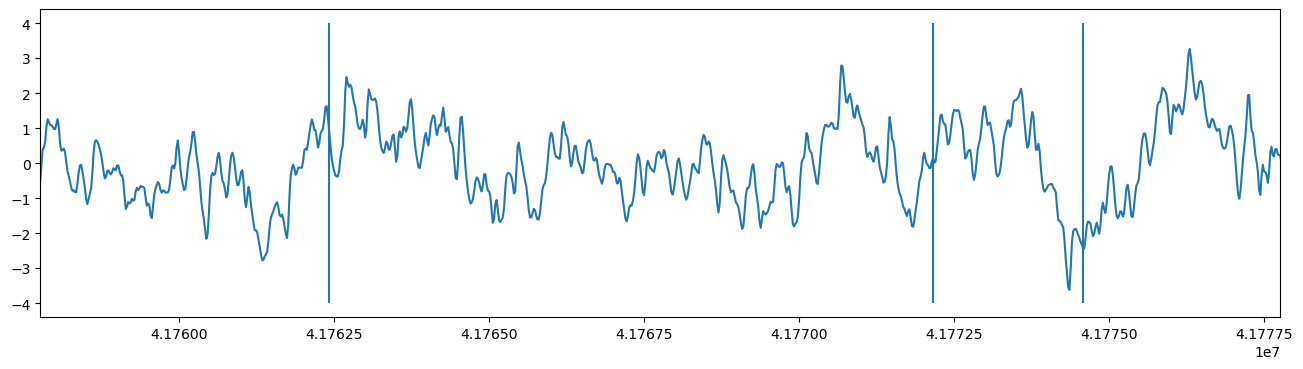

In [65]:
plt.figure(figsize=(16,4))
plt.plot(example_times, example_trace)
for time_stamp in aligned_spike_times:
    plt.vlines(x=time_stamp, ymin=-4, ymax=4)
plt.xlim(example_times[0],example_times[0] + EPHYS_SAMPLING_RATE)

(41757758.0, 41777758.0)

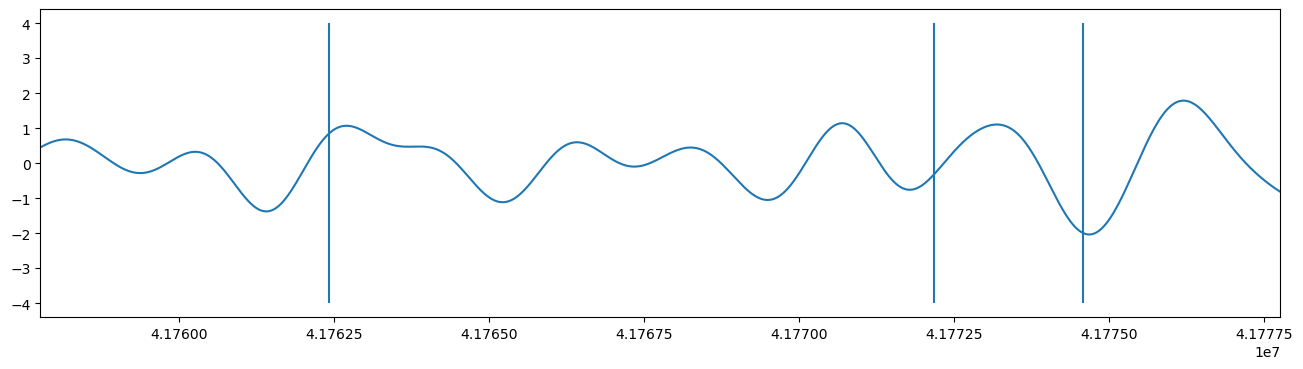

In [66]:
order=4
freq_band = [3, 12]
b, a = butter(order, freq_band, fs=LFP_SAMPLING_RATE, btype='band')
filt_data = filtfilt(b, a, example_trace, padtype=None)
plt.figure(figsize=(16,4))
plt.plot(example_times, filt_data)
for time_stamp in max_group_data:
    plt.vlines(x=time_stamp, ymin=-4, ymax=4)
plt.xlim(example_times[0],example_times[0] + EPHYS_SAMPLING_RATE)

(41757758.0, 41777758.0)

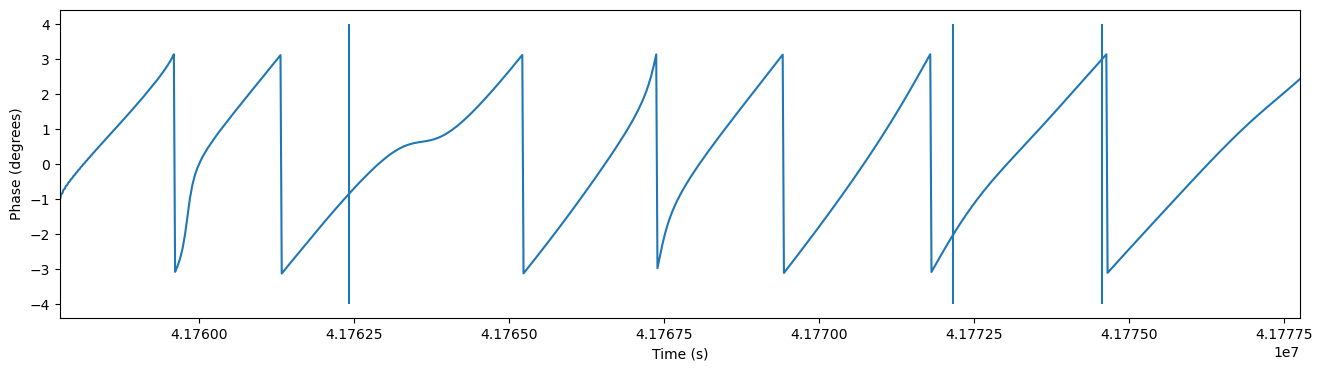

In [67]:
analytic_signal = hilbert(filt_data)
phase = np.angle(analytic_signal, deg=False)
plt.figure(figsize=(16,4))
plt.plot(example_times, phase)
plt.xlabel('Time (s)')
plt.ylabel('Phase (degrees)')
for time_stamp in max_group_data:
    plt.vlines(x=time_stamp, ymin=-4, ymax=4)
plt.xlim(example_times[0],example_times[0] + EPHYS_SAMPLING_RATE)

In [68]:
aligned_spike_indices = find_closest_indices(max_group_data, example_times)

In [69]:
spike_phases = []
for spike_time in aligned_spike_indices:
    spike_phases.append(phase[spike_time])


[0. 4. 3. 2. 3. 1. 2. 4. 2. 1. 1. 0. 3. 0. 1. 1. 1. 1. 4.]


<BarContainer object of 19 artists>

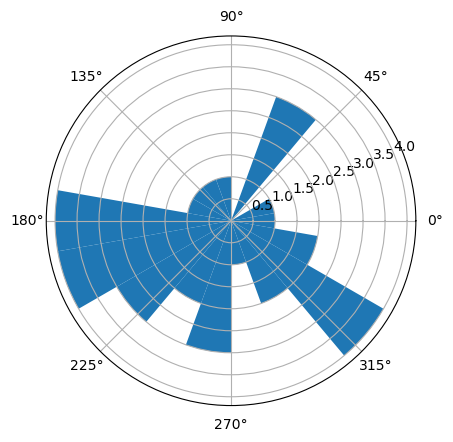

In [70]:
n_bins = 18
phase_bins = np.linspace(-np.pi, np.pi, n_bins+1)
binned_phases = np.digitize(spike_phases, phase_bins, n_bins+1)
spike_phase_hist = np.zeros(n_bins+1)
for bin in range(0, n_bins + 1):
    spike_phase_hist[bin] = np.sum(binned_phases == bin)
print(spike_phase_hist)

#Plot
ax = plt.subplot(1,1,1, polar=True)
plt.bar(phase_bins, spike_phase_hist, width=phase_bins[1] - phase_bins[0], bottom=0.0)